<a href="https://colab.research.google.com/github/CarloRomeoGitHub/ML-exercises/blob/master/SeminarioEsercitazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
!pip install pyod
!pip install --upgrade pyod

     |████████████████████████████████| 92kB 4.6MB/s 
     |████████████████████████████████| 5.4MB 14.1MB/s 
  Created wheel for pyod: filename=pyod-0.7.5.1-cp36-none-any.whl size=96256 sha256=b228a015a1f1b8d0b92bb94abe1d82a3bc7406e4f41253b093924d791fba72c3
  Stored in directory: /root/.cache/pip/wheels/ff/bf/31/2cd882186a1fffffe3b90b25056b6a7dcd6183b4336faaea55
Successfully built pyod
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


Requirement already up-to-date: pyod in /usr/local/lib/python3.6/dist-packages (0.7.5.1)


In [0]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from tensorflow.keras import callbacks
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from scipy import stats
from pyod.models.abod import ABOD
from pyod.models.knn import KNN


In [0]:
path = 'data.csv'
header = ['SeqName', 'TagID', 'Timestamp', 'Date', 'x','y','z','Activity']
df = pd.read_csv(path, header=None, sep=";", names=header, decimal=",")
dfcol = df.columns

#df = df.sort_values(['SequenceName', 'date','activity'], ascending=True)
nominal_features=['SeqName','TagID', 'Timestamp', 'Activity']
for f in nominal_features:
    le = LabelEncoder()
    unique_values =df[f].unique()
    le.fit(unique_values)
    df[f] = le.transform(df[f])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164860 entries, 0 to 164859
Data columns (total 8 columns):
SeqName      164860 non-null int64
TagID        164860 non-null int64
Timestamp    164860 non-null int64
Date         164860 non-null object
x            164860 non-null float64
y            164860 non-null float64
z            164860 non-null float64
Activity     164860 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 10.1+ MB
None
   SeqName  TagID  Timestamp  ...        y          z  Activity
0        0      0          0  ...  189.243    0.50743        10
1        0      3          0  ...  178.114  134.45000        10
2        0      2          0  ...  182.646    0.96882        10
3        0      0          0  ...  188.000    0.46698        10
4        0      1          0  ...  207.246    0.48806        10

[5 rows x 8 columns]


In [0]:
features = [ 'TagID', 'x', 'y', 'z'] #, 'Activity']
scaler = preprocessing.MinMaxScaler().fit(df[features])
dfscaler = scaler.transform(df[features])
features = [ 'TagID', 'x', 'y', 'z']
dfscaler = pd.DataFrame(dfscaler, columns = features)
dfscaler["Activity"] = df["Activity"]



print(dfscaler)

           TagID         x         y         z  Activity
0       0.000000  0.705736  0.476363  0.494918        10
1       1.000000  0.745490  0.448422  0.755015        10
2       0.666667  0.757146  0.459800  0.495814        10
3       0.000000  0.710060  0.473242  0.494839        10
4       0.333333  0.751133  0.521562  0.494880        10
...          ...       ...       ...       ...       ...
164855  0.333333  0.557591  0.514560  0.494055        10
164856  0.000000  0.588386  0.504557  0.494700        10
164857  1.000000  0.554019  0.482210  0.756683        10
164858  0.333333  0.547297  0.486087  0.494040        10
164859  0.000000  0.557681  0.488201  0.494641        10

[164860 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
features = ['x', 'y', 'z', 'Activity']
x = dfscaler[features]
y = dfscaler['TagID']
print(y)




0         0.000000
1         1.000000
2         0.666667
3         0.000000
4         0.333333
            ...   
164855    0.333333
164856    0.000000
164857    1.000000
164858    0.333333
164859    0.000000
Name: TagID, Length: 164860, dtype: float64


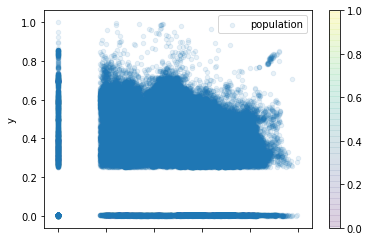

In [0]:
dfscaler.plot(kind = "scatter", x = "x", y = "y", alpha = 0.1,
              label = "population", 
             cmap = plt.get_cmap("jet"), colorbar= True)
plt.legend()

[[1.30217521 1.33909702 0.41281516 0.28883711 1.54715685]
 [1.42781736 1.58217121 0.21363337 3.56962836 1.54715685]
 [0.51781983 1.65344198 0.29474505 0.27554592 1.54715685]
 ...
 [1.42781736 0.41142009 0.45449854 3.59437346 1.54715685]
 [0.39217769 0.37032397 0.48213235 0.30186905 1.54715685]
 [1.30217521 0.43381493 0.49720208 0.29294641 1.54715685]]


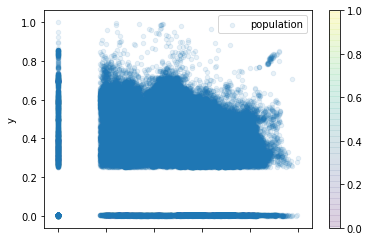

In [0]:
dfscaler.plot(kind = "scatter", x = "x", y = "y", alpha = 0.1,
              label = "population", 
             cmap = plt.get_cmap("jet"), colorbar= True)
plt.legend()

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

In [0]:
outlier_fraction = 0.1
x_out, x_in = get_outliers_inliers(x_train, y_train)
n_in = len(x_int)
n_out = len(x_out)

In [0]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
def modello():
  model = Sequential()
  
  
  model.add(Dense(128, input_dim = 4, activation = 'relu'))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(4, activation = 'softmax'))
  model.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model
modello = modello()
modello.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 11,108
Trainable params: 11,108
Non-trainable params: 0
_________________________________________________________________


In [0]:
def conv():
  model = Sequential()
  model.add(Conv1D(64, 4, activation = "relu", padding = "same", input_shape = (4,)))

#Parametri:
#7x7=49 pesi
#1 bias
#50 parametri; 50 x 64 = 3200

  model.add(Conv1D(128,4, activation = "relu", padding ="same"))
  model.add(Conv1D(128,4, activation = "relu", padding ="same")) #ci sono due layers computazionali, per questo è ripetuto
  model.add(MaxPooling1D(2))
  model.add(Conv1D(256,4, activation = "relu", padding ="same"))
  model.add(Conv1D(256,4, activation = "relu", padding ="same"))
  model.add(MaxPooling1D(2))
  model.add(Flatten())
  model.add(Dense(128, activation = "softmax"))
  model.add(Dropout(0.5))
#layer di dropout(attivo solo in fase di addestramento): server per evitare l'overfittng e facilitare il learning.
#Durante l'addestramente inibisce ad ogni passo una percentuale di neuroni, e cerca di far riconoscere gli oggetti usando solo una parte di neuroni
# 0.5 è la percentuale di neuroni che escludo dal task

  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = "softmax"))

#compilazione modello 
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.summary()
  return model
modello = conv()


In [0]:
num_epochs = 20
early_stop = callbacks.EarlyStopping(monitor = 'val_loss', patience = 30)

history = modello.fit(x_train, y_train, epochs = num_epochs, batch_size= 50, validation_data=(x_val, y_val), callbacks = [early_stop])





Train on 118699 samples, validate on 13189 samples
Epoch 1/20
118699/118699 [==============================] - 5s 42us/sample - loss: 0.2625 - acc: 0.3978 - val_loss: 0.2583 - val_acc: 0.4084
Epoch 2/20
118699/118699 [==============================] - 5s 42us/sample - loss: 0.2623 - acc: 0.3976 - val_loss: 0.2635 - val_acc: 0.4063
Epoch 3/20
118699/118699 [==============================] - 5s 43us/sample - loss: 0.2618 - acc: 0.3986 - val_loss: 0.2608 - val_acc: 0.4135
Epoch 4/20
118699/118699 [==============================] - 5s 41us/sample - loss: 0.2610 - acc: 0.3987 - val_loss: 0.2641 - val_acc: 0.4000
Epoch 5/20
118699/118699 [==============================] - 5s 43us/sample - loss: 0.2609 - acc: 0.3983 - val_loss: 0.2602 - val_acc: 0.3977
Epoch 6/20
118699/118699 [==============================] - 5s 43us/sample - loss: 0.2613 - acc: 0.3981 - val_loss: 0.2567 - val_acc: 0.4089
Epoch 7/20
118699/118699 [==============================] - 5s 42us/sample - loss: 0.2607 - acc: 0.3984

In [0]:
score = modello.evaluate( x_train, y_train)
print("\n Training Accuracy", score[1])
score = modello.evaluate(x_test, y_test)
print (" \n Testing Accuracy", score[1])

118699/118699 [==============================] - 5s 39us/sample - loss: 0.2558 - acc: 0.4077

 Training Accuracy 0.40770352
32972/32972 [==============================] - 1s 38us/sample - loss: 0.2623 - acc: 0.4107
 
 Testing Accuracy 0.41071212


In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
xc=range(num_epochs)


KeyError: ignored

In [0]:

fig = plt.figure(1, figsize=(7,5))
plt.plot(xc,train_loss)

plt.plot(xc,val_loss)
plt.xlabel('Number of episodes')
plt.ylabel('loss')
plt.grid(True)
plt.legend(['Training', 'Validation'])
fig.savefig('result-3.png')

fig = plt.figure(2, figsize=(7,5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('Number of episodes')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Training', 'Validation'])
fig.savefig('result-4.png')